# Embedding Different Variables into Different Spaces by GloVe

In this notebook we try to use Keras backend implement the optimization problem of GloVe. 
$$J = \sum_{i, j=1}^{V}f(X_{ij})((\mathbf{w}_i^k)^T\mathbf{M}^{kl}\mathbf{v_j}^l + b_i^k + a_j^l - \log X_{ij})^2$$
$$ \mathbf{W^k}, \mathbf{V^l}, \mathbf{b^k}, \mathbf{a^l} = \text{argmin}(J)$$
where $k, l \in \{DX1, DX, PR\}$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os, sys
from importlib import reload
import scipy.sparse as sp
import time
import itertools
%matplotlib inline

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
from keras.layers import Input, Embedding, Concatenate, Reshape, BatchNormalization, Lambda, Multiply, Add
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.initializers import Constant
import keras.backend as K

Using TensorFlow backend.


In [11]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint
from utils import Mat_reg, Parent_reg, preprocess, get_frequency
from glove import Glove
from setsum_layer import MaskedSum

In [6]:
from ccs_tools import dx_multi, pr_multi, dx_label, core_dtypes_pd, dx_single

## Class Developing
### Reading Data

In [7]:
cohort='ami'
tst_seed=0

In [8]:
all_df = pd.read_csv(path+'cohorts/{}/{}_pred.csv'.format(cohort, cohort), dtype=core_dtypes_pd)

In [9]:
n_DX = 29
n_PR = 15
DXs = ['DX'+str(n) for n in range(2, n_DX+2)]
PRs = ['PR'+str(n) for n in range(1, n_PR+1)]

In [12]:
freq = get_frequency(all_df)

In [13]:
preprocessed = preprocess(all_df, DX_rarecutpoint=10, PR_rarecutpoint=10)

In [14]:
all_df = preprocessed['int_df']

In [15]:
tst_key = pd.read_csv(path+'cohorts/{}/tst_key{}.csv'.format(cohort, tst_seed), names = ['KEY_NRD'])
tst_df = all_df.loc[all_df.KEY_NRD.isin(tst_key.KEY_NRD)]
train_df0 = all_df.loc[~all_df.KEY_NRD.isin(tst_key.KEY_NRD)].reset_index()

In [16]:
from glove import Glove

In [17]:
embed_dim=100
count_cap=5

In [18]:
g = Glove(input_dim=len(preprocessed['code_cat']), embedding_dim=embed_dim, count_cap=count_cap)

In [19]:
g.update_cooccur(train_df0[['DX1']+DXs+PRs])

Updating co-occurrence matrix from a Dataframe with 167841 rows...
Finished. It takes 34.7 seconds to update the cooccurrences.


In [20]:
cooccur_df = g.get_cooccur_df()

In [21]:
cooccur_df.shape

(874770, 3)

In [22]:
cooccur_df.head()

,focal_index,context_index,cooccur_counts
0,1294,1131,112.0
1,1760,65,1.0
2,1082,437,12.0
3,2440,1696,3.0
4,1006,901,5172.0


### Data preparation

In [23]:
n_DX1_cat = len(preprocessed['DX1_cat'])
n_DX_cat = len(preprocessed['DX_cat'])
n_PR_cat = len(preprocessed['PR_cat'])

In [24]:
n_DX1_cat, n_DX_cat, n_PR_cat

(20, 2323, 560)

In [25]:
input_X = cooccur_df

In [26]:
input_X = input_X.assign(input_DX1_w=0).assign(input_DX_w=0).assign(input_PR_w=0).assign(input_DX1_v=0).assign(input_DX_v=0).assign(input_PR_v=0)

input_X.loc[input_X.context_index<=n_DX1_cat, 'input_DX1_w'] = input_X.loc[input_X.context_index<=n_DX1_cat, 'context_index']

input_X.loc[(n_DX1_cat<input_X.context_index) & (input_X.context_index<=n_DX1_cat+n_DX_cat), 
            'input_DX_w'] = input_X.loc[(n_DX1_cat<input_X.context_index) & (input_X.context_index<=n_DX1_cat+n_DX_cat), 
                                        'context_index'] - n_DX1_cat

input_X.loc[input_X.context_index>n_DX1_cat+n_DX_cat, 
            'input_PR_w'] = input_X.loc[input_X.context_index>n_DX1_cat+n_DX_cat, 'context_index'] - n_DX1_cat - n_DX_cat

input_X.loc[input_X.focal_index<=n_DX1_cat, 'input_DX1_v'] = input_X.loc[input_X.focal_index<=n_DX1_cat, 'focal_index']

input_X.loc[(n_DX1_cat<input_X.focal_index) & (input_X.focal_index<=n_DX1_cat+n_DX_cat), 
            'input_DX_v'] = input_X.loc[(n_DX1_cat<input_X.focal_index) & (input_X.focal_index<=n_DX1_cat+n_DX_cat), 
                                        'focal_index'] - n_DX1_cat

input_X.loc[input_X.focal_index>n_DX1_cat+n_DX_cat, 
            'input_PR_v'] = input_X.loc[input_X.focal_index>n_DX1_cat+n_DX_cat, 'focal_index'] - n_DX1_cat - n_DX_cat

In [27]:
input_X.head(20)

,focal_index,context_index,cooccur_counts,input_DX1_w,input_DX_w,input_PR_w,input_DX1_v,input_DX_v,input_PR_v
0,1294,1131,112.0,0,1111,0,0,1274,0
1,1760,65,1.0,0,45,0,0,1740,0
2,1082,437,12.0,0,417,0,0,1062,0
3,2440,1696,3.0,0,1676,0,0,0,97
4,1006,901,5172.0,0,881,0,0,986,0
5,1891,877,4.0,0,857,0,0,1871,0
6,2159,1600,1.0,0,1580,0,0,2139,0
7,2826,1235,1.0,0,1215,0,0,0,483
8,1294,710,2.0,0,690,0,0,1274,0
9,1757,876,11.0,0,856,0,0,1737,0


In [37]:
DX1_w_trn = input_X['input_DX1_w'].values
DX1_v_trn = input_X['input_DX1_v'].values
DX_w_trn = input_X['input_DX_w'].values
DX_v_trn = input_X['input_DX_v'].values
PR_w_trn = input_X['input_PR_w'].values
PR_v_trn = input_X['input_PR_v'].values

In [39]:
y = np.log(input_X.cooccur_counts.values)

In [40]:
def weighting_factor(count, count_cap=5, scaling_factor=0.75):
    if count>=count_cap:
        return 1.
    else:
        return np.power(count/count_cap, scaling_factor)

In [41]:
weights = input_X.cooccur_counts.apply(weighting_factor).values

### Model building.

In [42]:
DX1_embed_dim = 10
DX_embed_dim = 100
PR_embed_dim = 50

In [43]:
input_DX1_w = Input(shape=(1,), name='input_focal_DX1')
input_DX_w = Input(shape=(1,), name='input_focal_DX')
input_PR_w = Input(shape=(1,), name='input_focal_PR')
input_DX1_v = Input(shape=(1,), name='input_context_DX1')
input_DX_v = Input(shape=(1,), name='input_context_DX')
input_PR_v = Input(shape=(1,), name='input_context_PR')

DX1_embed_layer = Embedding(input_dim=n_DX1_cat+1, output_dim=DX1_embed_dim, name='DX1_embed', mask_zero=True)
DX_embed_layer = Embedding(input_dim=n_DX_cat+1, output_dim=DX_embed_dim, name='DX_embed', mask_zero=True)
PR_embed_layer = Embedding(input_dim=n_PR_cat+1, output_dim=PR_embed_dim, name='PR_embed', mask_zero=True)

DX1_bias_layer = Embedding(input_dim=n_DX1_cat+1, output_dim=1, name='DX1_bias', mask_zero=True)
DX_bias_layer = Embedding(input_dim=n_DX_cat+1, output_dim=1, name='DX_bias', mask_zero=True)
PR_bias_layer = Embedding(input_dim=n_PR_cat+1, output_dim=1, name='PR_bias', mask_zero=True)

embed_DX1_w = DX1_embed_layer(input_DX1_w)
embed_DX1_v = DX1_embed_layer(input_DX1_v)
embed_DX_w = DX_embed_layer(input_DX_w)
embed_DX_v = DX_embed_layer(input_DX_v)
embed_PR_w = PR_embed_layer(input_PR_w)
embed_PR_v = PR_embed_layer(input_PR_v)

bias_DX1_w = DX1_bias_layer(input_DX1_w)
bias_DX1_v = DX1_bias_layer(input_DX1_v)
bias_DX_w = DX_bias_layer(input_DX_w)
bias_DX_v = DX_bias_layer(input_DX_v)
bias_PR_w = PR_bias_layer(input_PR_w)
bias_PR_v = PR_bias_layer(input_PR_v)

bias_DX1_w = Masking()(bias_DX1_w)
bias_DX1_v = Masking()(bias_DX1_v)
bias_DX_w = Masking()(bias_DX_w)
bias_DX_v = Masking()(bias_DX_v)
bias_PR_w = Masking()(bias_PR_w)
bias_PR_v = Masking()(bias_PR_v)

inner_DX1_DX = InnerProduct(matrix_shape=(DX1_embed_dim, DX_embed_dim), name='DX1dotDX')([embed_DX1_w, embed_DX_v])
inner_DX1_PR = InnerProduct(matrix_shape=(DX1_embed_dim, PR_embed_dim), name='DX1dotPR')([embed_DX1_w, embed_PR_v])
inner_DX_DX = InnerProduct(matrix_shape=(DX_embed_dim, DX_embed_dim), 
                           kernel_initializer=Constant(np.eye(DX_embed_dim)), name='DXdotDX')([embed_DX_w, embed_DX_v])
inner_PR_PR = InnerProduct(matrix_shape=(PR_embed_dim, PR_embed_dim), 
                           kernel_initializer=Constant(np.eye(PR_embed_dim)), name='PRdotPR')([embed_PR_w, embed_PR_v])
inner_DX_PR = InnerProduct(matrix_shape=(DX_embed_dim, PR_embed_dim), name='DXdotPR')([embed_DX_w, embed_PR_v])

bias_concat = Concatenate(axis=-1)([bias_DX1_w, bias_DX1_v, bias_DX_w, bias_DX_v, bias_PR_w, bias_PR_v])
bias_sum = Lambda(lambda x:K.sum(x, axis=-1, keepdims=False))(bias_concat)
inner_bias_sum = Add()([inner_DX1_DX, inner_DX1_PR, inner_DX_DX, inner_DX_PR, inner_PR_PR, bias_sum])

model = Model(inputs=[input_DX1_w, input_DX_w, input_PR_w, input_DX1_v, input_DX_v, input_PR_v], outputs=inner_bias_sum)

NameError: name 'Masking' is not defined

In [144]:
for l in model.layers:
    if (l.name=='DXdotDX') or (l.name=='PRdotPR'):
        l.trainable = False

In [145]:
model.compile(loss='mse', optimizer='adam')

In [146]:
earlystop_patience = 20
reducelr_patience = 10
batch_size = 128
epochs = 30

In [147]:
checkpoint = ModelCheckpoint(filepath=model_path+'glove_multi_temp.h5', monitor='loss', save_best_only=True, 
                             save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=reducelr_patience, min_lr=K.epsilon())
earlystop = EarlyStopping(monitor='loss', patience=earlystop_patience)

In [148]:
hist = model.fit([DX1_w_trn, DX_w_trn, PR_w_trn, DX1_v_trn, DX_v_trn, PR_v_trn], y, batch_size=batch_size, epochs=epochs,
                         sample_weight=weights, callbacks=[checkpoint, reduce_lr, earlystop], verbose=1)

Epoch 1/30
874770/874770 [==============================] - 76s 87us/step - loss: 0.5092
Epoch 2/30
874770/874770 [==============================] - 75s 86us/step - loss: 0.1507
Epoch 3/30
874770/874770 [==============================] - 75s 86us/step - loss: 0.1222
Epoch 4/30
874770/874770 [==============================] - 75s 86us/step - loss: 0.1088
Epoch 5/30
762368/874770 [=========================>....] - ETA: 9s - loss: 0.1001

KeyboardInterrupt: 

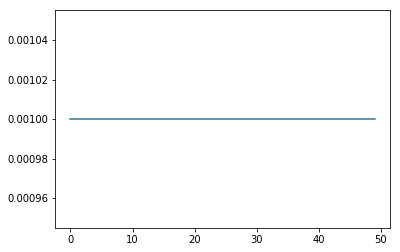

In [137]:
plt.plot(hist.history['lr'])

In [30]:
from keras.engine.topology import InputSpec, Layer

In [31]:
class InnerProduct(Layer):
    """The layer to perform a inner-product of two vectors through a matrix.   

    # Arguments
        matrix_shape: (dim1, dim2), shape of the matrix between the two vectors. 
        kernel_initializer: Initializer for the `kernel` weights matrix
    # Input shape
        [(batch, dim1), (batch, dim2)]
    # Output shape
        (batch, 1). This Dense layer works on the feature axis, and output units dimension.  
    """
    def __init__(self, matrix_shape=None,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(InnerProduct, self).__init__(**kwargs)
        self.matrix_shape = matrix_shape
        self.kernel_initializer = kernel_initializer
        self.supports_masking = True

    def build(self, input_shape):
        input_shape1, input_shape2 = input_shape
        if self.matrix_shape is None:
            self.matrix_shape = (input_shape1[-1], input_shape2[-1])
        elif not self.matrix_shape == (input_shape1[-1], input_shape2[-1]):
            raise ValueError('Initializer shape conflicts with inpute shape!')

        self.kernel = self.add_weight(shape=self.matrix_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel')
        self.built = True

    def call(self, inputs, mask=None):
        if not mask is None:
            mask1, mask2 = mask
        input1, input2 = inputs
        output = K.dot(input1, self.kernel)*input2
        output = K.sum(output, axis=-1)
        #mask1 = K.expand_dims(mask1)
        #mask2 = K.expand_dims(mask2)
        #print(output.shape, mask1.shape, mask2.shape)
        output = output*K.cast(mask1, 'float32')*K.cast(mask2, 'float32')
        return output

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        input_shape1, input_shape2 = input_shape
        assert input_shape1[0] == input_shape2[0]
        return (input_shape1[0], 1)
    
    def compute_mask(self, inputs, input_mask=None):
        return None

    def get_config(self):
        config = {
            'matrix_shape': self.matrix_shape,
            'kernel_initializer': initializers.serialize(self.kernel_initializer)
        }
        base_config = super(Dense, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [78]:
class Masking(Layer):
    """The layer to multipy the input with its mask.   

    # Arguments
        matrix_shape: (dim1, dim2), shape of the matrix between the two vectors. 
        kernel_initializer: Initializer for the `kernel` weights matrix
    # Input shape
        [(batch, dim1), (batch, dim2)]
    # Output shape
        (batch, 1). This Dense layer works on the feature axis, and output units dimension.  
    """
    def __init__(self, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(Masking, self).__init__(**kwargs)
        self.supports_masking = True

    def build(self, input_shape):
        self.built = True

    def call(self, inputs, mask=None):
        if mask is None:
            return inputs
        if K.ndim(mask)<K.ndim(inputs):
            mask_expand = K.expand_dims(mask)
        else:
            mask_expand = mask
        if not inputs.shape[1:]==mask_expand.shape[1:]:
            raise ValueError("The shapes of inputs and mask don't match!")
        output = inputs*K.cast(mask_expand, 'float32')
        return output

    def compute_output_shape(self, input_shape):
        return input_shape
    
    def compute_mask(self, inputs, input_mask=None):
        return None

### Parent regularization

In [96]:
dx1_ccs_dict = preprocessed['dx1_ccs_dict']
dx_ccs_dict = preprocessed['dx_ccs_dict']
pr_ccs_dict = preprocessed['pr_ccs_dict']

In [97]:
parent_pairs = preprocessed['parent_pairs']

In [98]:
parent_pairs[-10:]

[(3710, 3707),
 (3711, 3707),
 (3712, 3671),
 (3713, 3671),
 (3714, 3671),
 (3715, 3671),
 (3716, 3671),
 (3717, 3716),
 (3718, 3716),
 (3719, 3671)]

In [105]:
dx_ccs_indices = np.array(sorted(dx_ccs_dict.values()))

In [99]:
len(parent_pairs)

3687

In [31]:
dx1_ccs_dict

{'7': 2904, '7.2': 2905, '7.2.3': 2906}

In [36]:
input_X.head()

,focal_index,context_index,cooccur_counts,input_DX1_w,input_DX_w,input_PR_w,input_DX1_v,input_DX_v,input_PR_v
0,1294,1131,112.0,0,1111,0,0,1274,0
1,1760,65,1.0,0,45,0,0,1740,0
2,1082,437,12.0,0,417,0,0,1062,0
3,2440,1696,3.0,0,1676,0,0,0,97
4,1006,901,5172.0,0,881,0,0,986,0


## Class Testing

In [55]:
import glove
reload(glove)

<module 'glove' from '/home/wsliu/Codes/DLproj/NRD/glove.py'>

In [44]:
from glove import GloveMS

In [45]:
glovems = GloveMS(n_DX1_cat=n_DX1_cat, n_DX_cat=n_DX_cat, n_PR_cat=n_PR_cat, DX1_dim=10, DX_dim=100, PR_dim=50, count_cap = 5, 
                 scaling_factor=0.75)

In [25]:
glovems.update_cooccur(train_df0[['DX1']+DXs+PRs])

Updating co-occurrence matrix from a Dataframe with 167841 rows...
Finished. It takes 27.6 seconds to update the cooccurrences.


In [26]:
cooccur_df = glovems.get_cooccur_df()

In [46]:
glovems.train_glove(cooccur_df=cooccur_df, cache_path=model_path, verbose=1)

Preparing data...
Defining the GloVe model...
Training the GloVe model...
Epoch 1/50
874770/874770 [==============================] - 12s 14us/step - loss: 0.8262
Epoch 2/50
874770/874770 [==============================] - 11s 13us/step - loss: 0.2054
Epoch 3/50
874770/874770 [==============================] - 11s 13us/step - loss: 0.1552
Epoch 4/50
874770/874770 [==============================] - 11s 13us/step - loss: 0.1334
Epoch 5/50
874770/874770 [==============================] - 11s 13us/step - loss: 0.1196
Epoch 6/50
874770/874770 [==============================] - 11s 13us/step - loss: 0.1096
Epoch 7/50
874770/874770 [==============================] - 11s 13us/step - loss: 0.1022
Epoch 8/50
874770/874770 [==============================] - 11s 13us/step - loss: 0.0964
Epoch 9/50
874770/874770 [==============================] - 11s 13us/step - loss: 0.0916
Epoch 10/50
874770/874770 [==============================] - 11s 13us/step - loss: 0.0878
Epoch 11/50
874770/874770 [========

In [47]:
embeds = glovems.get_embed_mat()

In [38]:
embeds.keys()

dict_keys(['DX_bias', 'DX1_embed', 'DX1_bias', 'DX_embed', 'PR_embed', 'PR_bias'])

In [42]:
matrices = glovems.get_matrices()

In [44]:
matrices['DXdotPR'].shape

(100, 50)

### Co-Occurences from Whole Database

In [14]:
from ccs_tools import core_cols, core_dtypes_pd, na_values
from utils import get_frequency, preprocess

In [11]:
dxpr_df = pd.read_csv(path+'raw/2014/NRD_2014_Core.CSV', sep=',', 
                           header = None, 
                           names=core_cols, 
                           dtype=core_dtypes_pd, 
                           na_values=na_values, 
                           chunksize=500000)

In [28]:
DX1_freq = pd.read_csv(path+'all/DX1_freq.csv')
DX_freq = pd.read_csv(path+'all/DX_freq.csv')
PR_freq = pd.read_csv(path+'all/PR_freq.csv')

In [33]:
sum(DX1_freq.frequency == 0)/len(DX1_freq)

0.3434846072186836

In [ ]:
chunk_id = 0
for df in dxpr_df:
    start = time.time()
    freq = get_frequency(df)

In [34]:
cooccur_all = pd.read_csv(path+'all/sepdx1/cooccur_df_ami0.csv')

In [36]:
cooccur_all

,focal_index,context_index,cooccur_counts
0,27577,18219,43.0
1,26365,25684,5.0
2,27398,23975,2.0
3,23775,18539,2.0
4,20449,20247,76.0
5,17749,5398,28.0
6,30184,23274,1.0
7,29187,5182,2.0
8,31043,20114,4.0
9,23613,23106,2.0


In [50]:
DX_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)
PR_cat = ['missing'] + sorted(pr_multi.ICD9CM_CODE)

n_DX1_cat = len(DX_cat)-1
n_DX_cat = len(DX_cat)-1
n_PR_cat = len(PR_cat)-1

DX1_dict = dict(zip(DX_cat, range(len(DX_cat))))
DX_dict = dict(zip(DX_cat, [0] + list(range(len(DX_cat), len(DX_cat)*2))))
PR_dict = dict(zip(PR_cat, [0] + list(range(len(DX_cat)*2-1, len(DX_cat)*2+len(PR_cat)-1))))

code_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)*2 + sorted(pr_multi.ICD9CM_CODE)
n_code_cat = len(code_cat)

In [52]:
glovems = GloveMS(n_DX1_cat=n_DX1_cat, n_DX_cat=n_DX_cat, n_PR_cat=n_PR_cat, DX1_dim=10, DX_dim=100, PR_dim=50, count_cap = 5, 
                 scaling_factor=0.75)

In [54]:
glovems.train_glove(cooccur_df=cooccur_all, cache_path=model_path, epochs=1, verbose=1)

Preparing data...
Defining the GloVe model...
Training the GloVe model...
Epoch 1/1
17136813/17136813 [==============================] - 348s 20us/step - loss: 0.4450


FileNotFoundError: [Errno 2] No such file or directory: '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/models/glove_temp.h5'

## Embedding Visualization

In [48]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [49]:
from collections import defaultdict

In [50]:
DX_embed_mat = embeds['DX_embed']

In [81]:
DX_bias_mat = embeds['DX_bias']

In [51]:
DX_embed_mat.shape

(2324, 100)

In [17]:
DX_marg_freq = pd.read_csv(path+'all/sepdx1/DX_marg_freq.csv')

In [79]:
DX_freq = pd.read_csv(path+'all/DX_freq.csv')
DX1_freq = pd.read_csv(path+'all/DX1_freq.csv')
PR_freq = pd.read_csv(path+'all/PR_freq.csv')

In [52]:
DX_freq = freq['DX']

In [84]:
DX_freq = DX_freq.loc[DX_freq.index.isin(preprocessed['DX_cat'])].sort_index()

In [56]:
DX_freq.shape

(2323,)

In [61]:
preprocessed['DX_dict']['V8545']

2343

DX bias vs. marginal frequency:

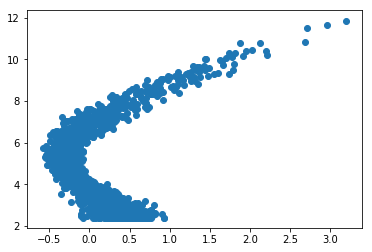

In [89]:
plt.scatter(DX_bias_mat[1:, 0], np.log(DX_freq.values))

In [64]:
DX_cat_clean = preprocessed['DX_cat']

In [62]:
tsne = TSNE(n_components=2, init='random', random_state=0)

In [68]:
start = time.time()
DX_tsne = tsne.fit_transform(DX_embed_mat[1:, :])
print('Time used: {} sec'.format(time.time()-start))

Time used: 16.78121280670166 sec


In [69]:
plot_df = pd.DataFrame(dict(x=DX_tsne[:, 0], y=DX_tsne[:, 1]), index=DX_cat_clean)

In [72]:
plot_df.head()

,x,y,ccs_lvl1
0059,-9.227467,3.677029,9 Diseases of the digestive system
00845,10.952630,-4.439830,9 Diseases of the digestive system
0088,1.721180,-0.810256,9 Diseases of the digestive system
0090,-3.788924,14.659010,9 Diseases of the digestive system
01190,-13.985912,2.130654,1 Infectious and parasitic diseases


CCS category labels:

In [71]:
plot_df = plot_df.assign(ccs_lvl1=[dx_multi.loc[dx, 'CCS_LVL1']+' '+dx_multi.loc[dx, 'CCS_LVL1_LABEL'] for dx in plot_df.index])

In [73]:
DX_freq = DX_freq.set_index(DX_freq.DX)
DX1_freq = DX1_freq.set_index(DX1_freq.DX1)

AttributeError: 'Series' object has no attribute 'set_index'

In [75]:
plot_df = plot_df.assign(freq=DX_freq.loc[plot_df.index])

In [76]:
plot_df = plot_df.assign(dot_size=plot_df.freq.apply(lambda x:np.log(x+1)**2/5))

In [77]:
colors = ['C{}'.format(j) for j in range(10)]

In [94]:
#groups = plot_df.groupby('freq_label')
groups = plot_df.loc[plot_df.freq>180].groupby('ccs_lvl1')
gkey = groups.size().sort_values(ascending=False).index

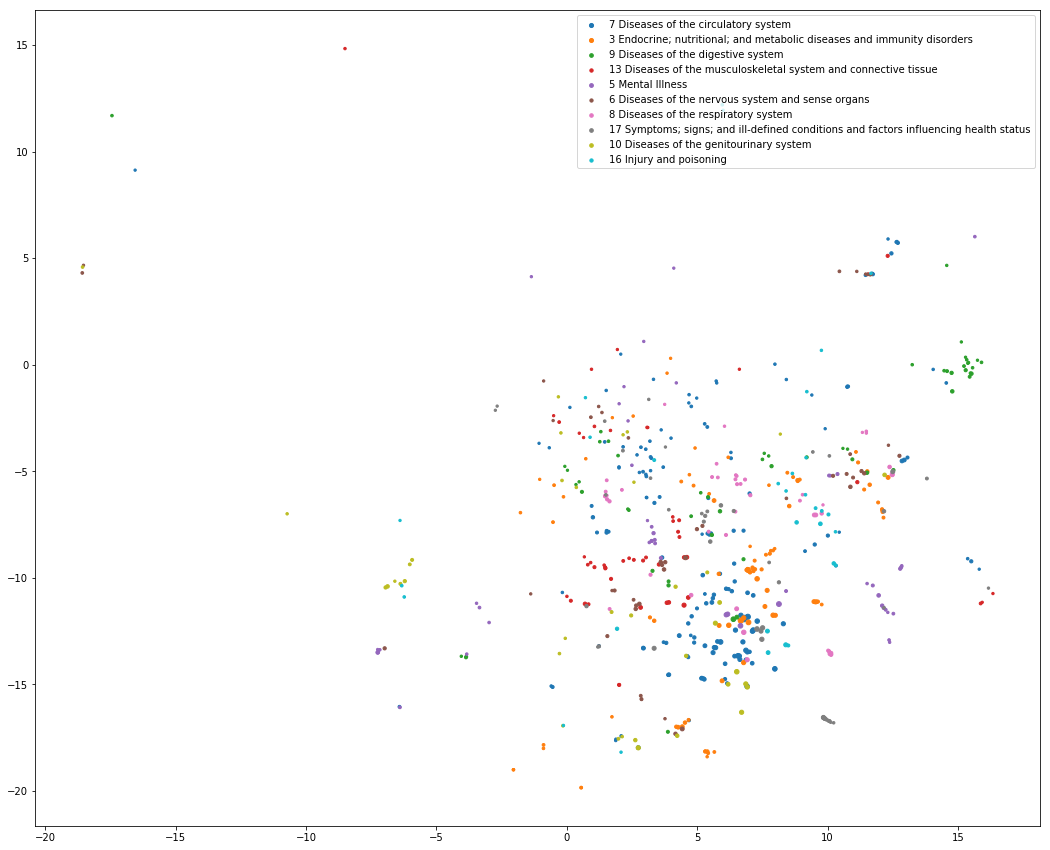

In [95]:
fig, ax = plt.subplots(figsize=(18, 15))
for ccs_lvl1, color in zip(gkey[:10], itertools.cycle(colors)):
    group = groups.get_group(ccs_lvl1)
    ax.scatter(group.x, group.y, marker='o', s=group.dot_size.values, label=ccs_lvl1, c=color)
    #plt.annotate(name, xy=(group.x.values, group.y.values), xytext=(group.x.values, group.y.values))
ax.legend()
#plt.savefig('output/embed.png', dpi=200)